In [1]:
pip install scalecast --upgrade


  Created wheel for scalecast: filename=SCALECAST-0.15.5-py3-none-any.whl size=107203 sha256=1e813a5608df25b2f82ab06538c5ee06cf8bb0151e1a433ca82d0b609c1ae4ca
  Stored in directory: c:\users\nehas\appdata\local\pip\cache\wheels\1e\82\d7\1c3fb2799326d2b3fb8c7c377fb3928eced18603555f78afe3
Successfully built scalecast
  Attempting uninstall: scalecast
    Found existing installation: SCALECAST 0.15.4
    Uninstalling SCALECAST-0.15.4:
      Successfully uninstalled SCALECAST-0.15.4


In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import plotly.express as px
import datetime
from datetime import timedelta,datetime
import pandas as pd
from sklearn.linear_model import LinearRegression
import sklearn.preprocessing 
import matplotlib.pyplot as pyplot
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error
from scalecast.Forecaster import Forecaster

In [3]:
#loading the cleaned data from PJMW_MW(eda file)
data1=pd.read_csv("out_clean_data.csv",index_col=0,parse_dates=True,header=0)
data1.head()

,energy,date,year,month,month_name,week_of_year,quarter,day_of_week,day_of_week_name,day_of_month,day_of_year,hour,time
Datetime,,,,,,,,,,,,,
2002-04-01 01:00:00,4374.0,2002-04-01,2002,4,April,14,2,0,Monday,1,91,1,01:00:00
2002-04-01 02:00:00,4306.0,2002-04-01,2002,4,April,14,2,0,Monday,1,91,2,02:00:00
2002-04-01 03:00:00,4322.0,2002-04-01,2002,4,April,14,2,0,Monday,1,91,3,03:00:00
2002-04-01 04:00:00,4359.0,2002-04-01,2002,4,April,14,2,0,Monday,1,91,4,04:00:00
2002-04-01 05:00:00,4436.0,2002-04-01,2002,4,April,14,2,0,Monday,1,91,5,05:00:00


In [4]:
data1.shape

(143232, 13)

In [5]:
df=data1.loc[:,'energy']

In [6]:
# Down sampling
df2=df.resample('D').mean()
df1=df2.asfreq('D')
data2=pd.DataFrame(df1)
data3=data2.copy()
data3

,energy
Datetime,
2002-04-01,5271.173913
2002-04-02,5310.416667
2002-04-03,5325.916667
2002-04-04,5670.791667
2002-04-05,5686.125000
...,...
2018-07-30,5492.708333
2018-07-31,5660.750000
2018-08-01,5959.708333


<AxesSubplot:xlabel='Datetime'>

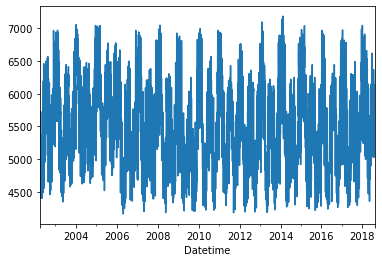

In [7]:
#data plot
data3['energy'].plot()

In [8]:
# saving dowmsampled data in csv  for deployement perspective
data3.to_csv('PJMW_MW.csv')

### Train and Test Split

In [9]:
# as there is weekly seasonality  ,so we will toke 7 days shift
data3['shift_1dayback']=data3['energy'].shift(+1)
data3['shift_2dayback']=data3['energy'].shift(+2)
data3['shift_3dayback']=data3['energy'].shift(+3)
data3['shift_4dayback']=data3['energy'].shift(+4)
data3['shift_5dayback']=data3['energy'].shift(+5)
data3['shift_6dayback']=data3['energy'].shift(+6)
data3['shift_7dayback']=data3['energy'].shift(+7)
data3.head(10)

,energy,shift_1dayback,shift_2dayback,shift_3dayback,shift_4dayback,shift_5dayback,shift_6dayback,shift_7dayback
Datetime,,,,,,,,
2002-04-01,5271.173913,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-04-02,5310.416667,5271.173913,NaN,NaN,NaN,NaN,NaN,NaN
2002-04-03,5325.916667,5310.416667,5271.173913,NaN,NaN,NaN,NaN,NaN
2002-04-04,5670.791667,5325.916667,5310.416667,5271.173913,NaN,NaN,NaN,NaN
2002-04-05,5686.125000,5670.791667,5325.916667,5310.416667,5271.173913,NaN,NaN,NaN
2002-04-06,5367.791667,5686.125000,5670.791667,5325.916667,5310.416667,5271.173913,NaN,NaN
2002-04-07,5052.208333,5367.791667,5686.125000,5670.791667,5325.916667,5310.416667,5271.173913,NaN
2002-04-08,5283.875000,5052.208333,5367.791667,5686.125000,5670.791667,5325.916667,5310.416667,5271.173913
2002-04-09,5136.083333,5283.875000,5052.208333,5367.791667,5686.125000,5670.791667,5325.916667,5310.416667


In [10]:
data3.shape

(5969, 8)

In [11]:
# dropping the nan values
df=data3.dropna()

In [12]:
df.shape

(5962, 8)

In [13]:
x1,x2,x3,x4,x5,x6,x7,y=df['shift_1dayback'],df['shift_2dayback'],df['shift_3dayback'],df['shift_4dayback'],df['shift_5dayback'],df['shift_6dayback'],df['shift_7dayback'],df['energy']
x1,x2,x3,x4,x5,x6,x7,y=np.array(x1),np.array(x2),np.array(x3),np.array(x4),np.array(x5),np.array(x6),np.array(x7),np.array(y)
x1,x2,x3,x4,x5,x6,x7,y=x1.reshape(-1,1),x2.reshape(-1,1),x3.reshape(-1,1),x4.reshape(-1,1),x5.reshape(-1,1),x6.reshape(-1,1),x7.reshape(-1,1),y.reshape(-1,1)
final_x=np.concatenate((x1,x2,x3,x4,x5,x6,x7),axis=1)
print(final_x)


[[5052.20833333 5367.79166667 5686.125      ... 5325.91666667
  5310.41666667 5271.17391304]
 [5283.875      5052.20833333 5367.79166667 ... 5670.79166667
  5325.91666667 5310.41666667]
 [5136.08333333 5283.875      5052.20833333 ... 5686.125
  5670.79166667 5325.91666667]
 ...
 [5660.75       5492.70833333 5293.83333333 ... 5978.75
  6024.51443113 6036.20833333]
 [5959.70833333 5660.75       5492.70833333 ... 5485.79166667
  5978.75       6024.51443113]
 [5805.04166667 5959.70833333 5660.75       ... 5293.83333333
  5485.79166667 5978.75      ]]


In [14]:
y

array([[5283.875     ],
       [5136.08333333],
       [5171.66666667],
       ...,
       [5959.70833333],
       [5805.04166667],
       [5489.        ]])

In [15]:
X_train,X_test,y_train,y_test=final_x[:-360],final_x[-360:],y[:-360],y[-360:]

In [16]:
X_train.shape,X_test.shape

((5602, 7), (360, 7))

In [17]:
y_train.shape,y_test.shape

((5602, 1), (360, 1))

### XGBOOST  MODEL

In [18]:
from xgboost import XGBRegressor

In [19]:
reg =XGBRegressor()

In [20]:
reg.fit(X_train,y_train,verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

## Forecast on test set

In [21]:
xgboost_pred=reg.predict(X_test)

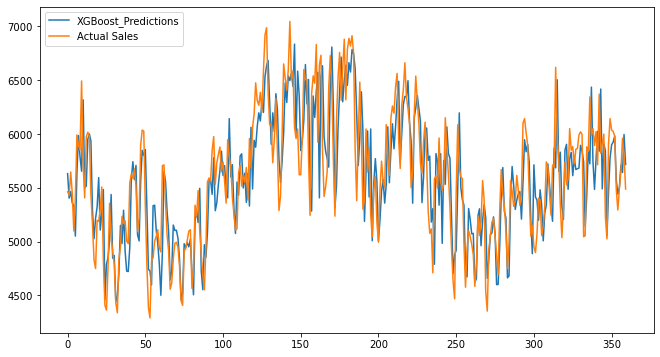

In [22]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11,6)
plt.plot(xgboost_pred,label='XGBoost_Predictions')
plt.plot(y_test,label='Actual Sales')
plt.legend(loc="upper left")
plt.show()

### Evaluate the Model

In [23]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error,mean_squared_error

In [24]:
MAE_XG = mean_absolute_error(y_test, xgboost_pred)
MAPE_XG= round((mean_absolute_percentage_error(y_test,xgboost_pred)*100),3)
RMSE_XG=np.sqrt(mean_squared_error(xgboost_pred,y_test))

xgboost_metric=({'RMSE':RMSE_XG,'MAPE':MAPE_XG,'MAE':MAE_XG})
xgboost_metric

{'RMSE': 342.11690457465994, 'MAPE': 4.823, 'MAE': 271.1710363138336}

## Random Forest Model

In [25]:
from sklearn.ensemble import RandomForestRegressor

In [26]:
model_rf=RandomForestRegressor(n_estimators=100,max_features=3,random_state=1)

In [27]:
model_rf.fit(X_train,y_train)

RandomForestRegressor(max_features=3, random_state=1)

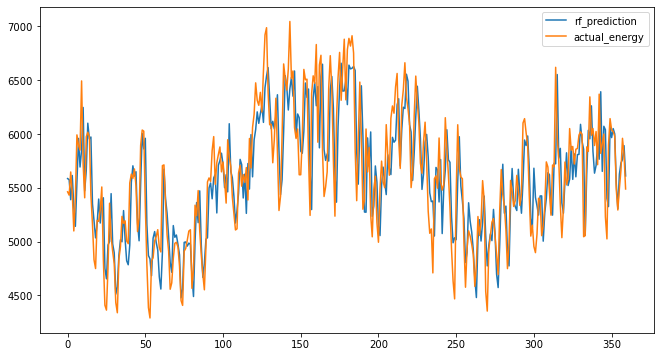

In [28]:
rf_prediction=model_rf.predict(X_test)
plt.rcParams["figure.figsize"] = (11,6)
plt.plot(rf_prediction,label='rf_prediction')
plt.plot(y_test,label='actual_energy')
plt.legend(loc='upper right')

### Evaluate the metric

In [29]:
AE_XG = mean_absolute_error(y_test, rf_prediction)
MAPE_XG= round((mean_absolute_percentage_error(y_test,rf_prediction)*100),3)
RMSE_XG=np.sqrt(mean_squared_error(rf_prediction,y_test))

random_forest_metric=({'RMSE':RMSE_XG,'MAPE':MAPE_XG,'MAE':MAE_XG})
random_forest_metric

{'RMSE': 324.61456740310985, 'MAPE': 4.576, 'MAE': 271.1710363138336}

In [30]:
# comapring both the metrics values 
print(random_forest_metric)
print(xgboost_metric)

{'RMSE': 324.61456740310985, 'MAPE': 4.576, 'MAE': 271.1710363138336}
{'RMSE': 342.11690457465994, 'MAPE': 4.823, 'MAE': 271.1710363138336}


### Evaluating Future Forcasting accuracy

In [31]:
#predction on the predicted data for future 7 days on both the models 
#to check which future prediction is giving better 

In [32]:
forcast_data=np.array(data3['energy'][:'2018-07-04'][-7:])

### Random forest model 

In [33]:
model=RandomForestRegressor(n_estimators=100,max_features=3,random_state=1)
model.fit(final_x,y)

RandomForestRegressor(max_features=3, random_state=1)

In [34]:
z=forcast_data
for i in range(0,30):
    ck=z[-7:]
    ck=np.array([ck])
    ck_pred=model.predict(ck)
    z=np.append(z,ck_pred)
    i=+1
    
    
forecast_randomforest=z[-30:]    

In [35]:
future=pd.date_range('2018-07-05','2018-08-03',freq='D')
future_pred=pd.DataFrame(index=future)

In [36]:
future_pred['future_energy_random_forest']=forecast_randomforest.tolist()

In [37]:
last_30daysdata=data3['energy'].tail(30)

Text(0, 0.5, 'Power consumption')

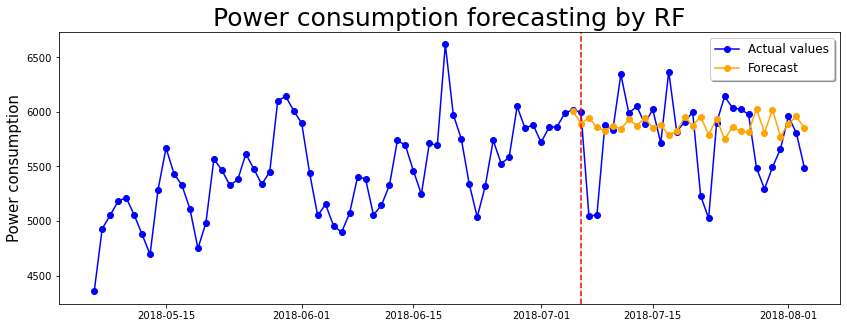

In [38]:
plt.figure(figsize=(14,5))
plt.title("Power consumption forecasting by RF", fontsize=25)

plt.plot(data3[-90:].index,data3[-90:]['energy'], label='Actual values', color="blue", marker="o")

plt.plot(future_pred.index,future_pred['future_energy_random_forest'], label='Forecast', color="orange", marker="o")
# plt.fill_between(future_df.index, lower_limits_f, upper_limits_f, alpha=0.1, color="orange")

plt.axvline(future_pred.index[1], color="red", linestyle="--")
plt.legend(fontsize=12, fancybox=True, shadow=True, frameon=True)
plt.ylabel('Power consumption', fontsize=15)

In [39]:
AE_XG = mean_absolute_error(last_30daysdata, future_pred['future_energy_random_forest'])
MAPE_XG= round((mean_absolute_percentage_error(last_30daysdata, future_pred['future_energy_random_forest'])*100),3)
RMSE_XG=np.sqrt(mean_squared_error(last_30daysdata, future_pred['future_energy_random_forest']))

random_forest_metric_forecast_check=({'RMSE':RMSE_XG,'MAPE':MAPE_XG,'MAE':MAE_XG})
random_forest_metric_forecast_check

{'RMSE': 389.727567534874, 'MAPE': 5.146, 'MAE': 271.1710363138336}

### XGBOOST MODEL

In [40]:
modelxgb=XGBRegressor()
modelxgb.fit(final_x,y,verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [41]:
z=forcast_data
for i in range(0,30):
    ck=z[-7:]
    ck_f=np.array([ck])
    ckh=modelxgb.predict(ck_f)
    z=np.append(z,ckh)
    i=+1
    
futurepred_xgb=z[-30:]    

In [42]:
futurepred_xgb

array([5930.04736328, 5939.62792969, 5932.53076172, 5814.9765625 ,
       5868.30273438, 5742.71337891, 5869.99902344, 5966.65136719,
       5889.60595703, 5912.35009766, 5853.45605469, 5935.83056641,
       5824.42871094, 5948.71142578, 6033.17041016, 5716.41259766,
       5976.94775391, 5786.01513672, 5908.13769531, 5762.4609375 ,
       6010.62207031, 6030.21386719, 5802.60595703, 6065.17089844,
       6002.33349609, 6014.13867188, 5618.96044922, 5966.12744141,
       5887.56445312, 5805.60888672])

In [43]:
date=pd.date_range('2018-07-05','2018-08-04',freq='D')
future_pred_xgb=pd.DataFrame(index=future)
future_pred_xgb['xgboost_future_energy']=futurepred_xgb.tolist()

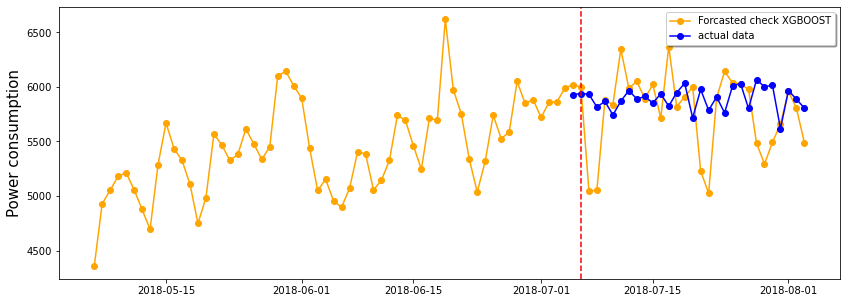

In [44]:
plt.figure(figsize=(14,5))
plt.plot(data3[-90:].index,data3[-90:]['energy'],label='Forcasted check XGBOOST',marker='o',color='orange')
plt.plot(future_pred_xgb.index,future_pred_xgb['xgboost_future_energy'],label='actual data',marker='o',color='blue')
plt.axvline(future_pred_xgb.index[1],color='red',linestyle='--')
plt.legend(fancybox=True,shadow=True,frameon=True)
plt.ylabel('Power consumption', fontsize=15)
plt.show()

### Evaluationg the forecasting metric

In [45]:
AE_XG = mean_absolute_error(last_30daysdata, future_pred_xgb['xgboost_future_energy'])
MAPE_XG= round((mean_absolute_percentage_error(last_30daysdata, future_pred_xgb['xgboost_future_energy'])*100),3)
RMSE_XG=np.sqrt(mean_squared_error(last_30daysdata, future_pred_xgb['xgboost_future_energy']))

xgboost_metric_forecast_check=({'RMSE':RMSE_XG,'MAPE':MAPE_XG,'MAE':MAE_XG})
xgboost_metric_forecast_check

{'RMSE': 393.80237456771823, 'MAPE': 5.088, 'MAE': 271.1710363138336}

In [46]:
print('XGBOOST ACCURACY',xgboost_metric_forecast_check)
print('RANDOM FOREST ACCURACY',random_forest_metric_forecast_check)

XGBOOST ACCURACY {'RMSE': 393.80237456771823, 'MAPE': 5.088, 'MAE': 271.1710363138336}
RANDOM FOREST ACCURACY {'RMSE': 389.727567534874, 'MAPE': 5.146, 'MAE': 271.1710363138336}


In [47]:
#there is not much a difference in the metrics .
#we can choose either of them 
# i will choose the random forest as my final model

## FINAL MODEL

### RANDOM FOREST

In [48]:
data4=data3.dropna()

In [49]:
data4

,energy,shift_1dayback,shift_2dayback,shift_3dayback,shift_4dayback,shift_5dayback,shift_6dayback,shift_7dayback
Datetime,,,,,,,,
2002-04-08,5283.875000,5052.208333,5367.791667,5686.125000,5670.791667,5325.916667,5310.416667,5271.173913
2002-04-09,5136.083333,5283.875000,5052.208333,5367.791667,5686.125000,5670.791667,5325.916667,5310.416667
2002-04-10,5171.666667,5136.083333,5283.875000,5052.208333,5367.791667,5686.125000,5670.791667,5325.916667
2002-04-11,5207.875000,5171.666667,5136.083333,5283.875000,5052.208333,5367.791667,5686.125000,5670.791667
2002-04-12,5090.416667,5207.875000,5171.666667,5136.083333,5283.875000,5052.208333,5367.791667,5686.125000
...,...,...,...,...,...,...,...,...
2018-07-30,5492.708333,5293.833333,5485.791667,5978.750000,6024.514431,6036.208333,6142.666667,5900.041667
2018-07-31,5660.750000,5492.708333,5293.833333,5485.791667,5978.750000,6024.514431,6036.208333,6142.666667
2018-08-01,5959.708333,5660.750000,5492.708333,5293.833333,5485.791667,5978.750000,6024.514431,6036.208333


In [95]:
data4.to_csv('data.csv')

In [50]:
regresser=RandomForestRegressor(n_estimators=100,max_features=3,random_state=1)

In [51]:
regresser.fit(final_x,y)

RandomForestRegressor(max_features=3, random_state=1)

In [96]:
model=regresser.fit(final_x,y)

In [100]:
last_7days=np.array(data3['energy'].tail(7))

In [101]:
last_7days

array([5485.79166667, 5293.83333333, 5492.70833333, 5660.75      ,
       5959.70833333, 5805.04166667, 5489.        ])

In [102]:
type(last_7days)

numpy.ndarray

In [103]:
data=pd.DataFrame(last_7days)
data.to_csv('last_7days.csv')

In [104]:
z=last_7days

for i in range(0,30):
    r=z[-7:]
    r=np.array([r])
    ranf_f=regresser.predict(r)
    z=np.append(z,ranf_f)
    i=+1
future_pred=z[-30:]

In [105]:
future_pred

array([5715.92293293, 5269.47791667, 5570.04235218, 5550.46775258,
       5942.61012631, 5809.77436396, 5580.90587923, 5885.57214617,
       5373.23521647, 5815.98204819, 5346.01048197, 5880.8450627 ,
       5749.30434128, 5670.51796025, 5959.48192277, 5406.69700887,
       5929.81933487, 5290.02651405, 5830.10185662, 5617.69977362,
       5760.70338213, 5900.52903557, 5387.03916667, 5952.89945694,
       5231.35747644, 5815.12480555, 5511.2792842 , 5656.09132712,
       5906.68670682, 5467.30847764])

In [106]:
future=pd.date_range('2018-08-04','2018-09-02',freq='D')
future_df=pd.DataFrame(index=future)
future_df['future_energy']=future_pred.tolist()
future_df

,future_energy
2018-08-04,5715.922933
2018-08-05,5269.477917
2018-08-06,5570.042352
2018-08-07,5550.467753
2018-08-08,5942.610126
2018-08-09,5809.774364
2018-08-10,5580.905879
2018-08-11,5885.572146
2018-08-12,5373.235216
2018-08-13,5815.982048


In [107]:
# for next 30 days
future_df.shape

(30, 1)

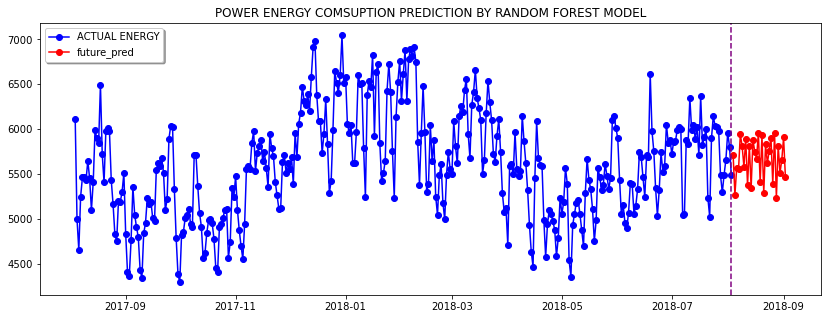

In [58]:
# plotting the future prediction 
plt.figure(figsize=(14,5))
plt.title('POWER ENERGY COMSUPTION PREDICTION BY RANDOM FOREST MODEL')

plt.plot(data2[-365:].index,data2[-365:].values,label='ACTUAL ENERGY',marker='o',color='blue')
plt.plot(future_df.index,future_df.values,label='future_pred',marker='o',color='red')
plt.axvline(data2.index[-1:],color='purple',linestyle="--")
plt.legend(loc='upper left',fancybox=True,shadow=True,frameon=True)
plt.show()

In [99]:
# creating a pickle file 
import pickle
pickleout=open('regresser.sav',"wb")
pickle.dump(regresser,pickleout)
pickleout.close()